# Monthly Mosaic

_12 Dec 2021_

_by Alex Berndt_

__Abstract__


## Import Dependencies

In [1]:
import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import coiled

import xrspatial.multispectral as ms

import dask.distributed
from dask_gateway import GatewayCluster

/home/alex/anaconda3/envs/coiled-coiled-default/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


## Start Dask Cluster

Using Dask Cluster hosted by coiled.

In [2]:
# Create a remote Dask cluster with Coiled
cluster = coiled.Cluster(
    name="stackstac",
    software="gjoseph92/stackstac",
    n_workers=8,
)

# Connect Dask to that cluster
client = dask.distributed.Client(cluster)
print("Dask Dashboard:", client.dashboard_link)

Output()

Found software environment build
Created fw rule: inbound [22-22] [0.0.0.0/0] []
Created fw rule: inbound [8786-8786] [0.0.0.0/0] []
Created fw rule: inbound [8787-8787] [0.0.0.0/0] []
Created FW rules: coiled-dask-graphif92-78778-firewall
Created fw rule: inbound [0-65535] [None] [coiled-dask-graphif92-78778-firewall]
Created scheduler VM: coiled-dask-graphif92-78778-scheduler (type: t3.medium, ip: ['44.200.119.24'])


Dask Dashboard: http://44.200.119.24:8787


/home/alex/anaconda3/envs/coiled-coiled-default/lib/python3.9/site-packages/distributed/client.py:1131: VersionMismatchWarning: Mismatched versions found

+---------+---------------+----------------+----------------+
| Package | client        | scheduler      | workers        |
+---------+---------------+----------------+----------------+
| blosc   | 1.10.2        | None           | None           |
| lz4     | 3.1.10        | None           | None           |
| numpy   | 1.21.4        | 1.21.1         | 1.21.1         |
| python  | 3.9.7.final.0 | 3.8.12.final.0 | 3.8.12.final.0 |
+---------+---------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [3]:
import stackstac
import pystac_client
from rasterio.enums import Resampling

In [13]:
%%time
items = pystac_client.Client.open(
    "https://earth-search.aws.element84.com/v0"
).search(
    intersects=dict(type="Point", coordinates=[-106, 35.7]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2020-01-01/2020-02-01",
    limit=10_000,
).get_all_items()
len(items)

CPU times: user 26 ms, sys: 657 µs, total: 26.7 ms
Wall time: 1.54 s


26

In [34]:
# Import python packages
from rasterio.warp import calculate_default_transform
from shapely.geometry import Polygon, mapping
from datetime import datetime
from itertools import islice
from typing import Dict, List, Tuple
import pystac

from helper import (
    read_json, 
    get_metadata_path,
    get_udm_file_path,
    get_udm2_file_path,
    get_tif_file_path,
    get_COG_file_path,
)

# Define item id's saved in `./assets/` dir
item_ids = [
    '20210425_100412_ssc3_u0001',
    '20210425_100412_ssc3_u0002',
    '20210528_131522_ssc9_u0001',
    '20210710_133141_ssc8_u0001',
    '20210922_100732_ssc12_u0001',
    '20210922_100732_ssc12_u0002',
]

def create_STAC_Item(
    tiff_path: str, 
    metadata_json: Dict,
    catalog: pystac.STACObject,
) -> Tuple[pystac.Item, Tuple]:
    """Creates a STAC item.
    
    Args:
        tiff_path (str): path to the COG file.
        metadata_json (Dict): dict content of metadata.json file.
        
    Returns:
        List of STAC items.
    """

    with rasterio.open(tiff_path) as sample_cog:
        
        bounds = sample_cog.bounds
        src_crs = sample_cog.crs
        dst_crs = 'EPSG:4326'  # EPSG identifier for WGS84 coordinate system used by the geojson format
        
        left, bottom, right, top = rasterio.warp.transform_bounds(sample_cog.crs, dst_crs, *bounds)
        bbox = [left, bottom, right, top]
        
        # Create geojson feature
        geom = mapping(Polygon([
          [left, bottom],
           [left, top],
           [right, top],
           [right, bottom]
        ]))
        
        time_acquired = datetime.strptime(metadata_json["properties"]["acquired"][:-1], '%Y-%m-%dT%H:%M:%S.%f')
        
        # Instantiate pystac item
        item = pystac.Item(id=metadata_json["id"],
                             geometry=geom,
                             bbox=bbox,
                             datetime=time_acquired,
                             properties={},
                          )
        
        # links=[pystac.Link(rel='item', target=catalog)]

        # Use Planet metadata.json to add some common metadata to the STAC item
        metadata_properties = metadata_json["properties"]
        
        # TODO: Enable item extensions
        # item.ext.enable('eo')
        # item.ext.enable('view') 
        # item.ext.enable('projection')
        
        for key, value in islice(metadata_properties.items(), 1, None):

            # Add some common metadata for the item not included in the core item specification
            
            # Ground Sample Distance
            if(key == 'gsd'):
                item.common_metadata.gsd = value
                
            # TODO: Could not add item.ext - item has no ext? Need to investigate

        # Tuple containing spatial and temporal extent information to use later in this tutorial
        item_extent_info =  (bbox, geom, time_acquired)
     
    # Returns a list containing the PySTAC Item object and a tuple 
    # holding the bounding box, geojson polygon, and date the item was acquired
    return item, (item_extent_info)

def create_STAC_Items(item_ids: List[str], catalog: pystac.STACObject) -> List[Tuple]:
    """ Create STAC Items.
    
    Args:
        item_ids (List[str]):  
    
    Returns:
        stac_items (List[Tuple]): list of STAC items
    """
    item_ids = sorted(item_ids, reverse=True)

    # empty list to store STAC items
    stac_items = []
    
    for item_id in item_ids:
        
        metadata_path = get_metadata_path(item_id)
        metadata_json = read_json(metadata_path)
        url_udm = get_udm_file_path(item_id)
        url_udm2 = get_udm2_file_path(item_id)
        url_tif = get_tif_file_path(item_id)
        url_cog = get_COG_file_path(item_id)

        # Create STAC Items
        item, extent = create_STAC_Item(
            tiff_path=url_tif, 
            metadata_json=metadata_json,
            catalog=catalog,
        )

        # Add COG asset to STAC items list
        item.add_asset(
              key='COG',
              asset=pystac.Asset(
                  href=url_cog,
                  title= f"{item_id} - COG PSScene4Band",
                  # indicate it is a cloud optimized geotiff
                  media_type=pystac.MediaType.COG,
                  roles=([
                    "analytic"
                  ])
              )
        ) 
        
        # Add UDM2 asset to STAC items list
        item.add_asset(
              key='UDM2',
              asset=pystac.Asset(
                  href=url_udm2,
                  title= f"{item_id} - Usable Data Masks (UDM2)",
                  media_type=pystac.MediaType.TIFF,
                  roles=([
                    "analytic"
                  ])
              )
        ) 
        
        # Add UDM asset to STAC items list
        item.add_asset(
              key='UDM',
              asset=pystac.Asset(
                  href=url_udm,
                  title= f"{item_id} - Unusable Data Masks (UDM)",
                  media_type=pystac.MediaType.TIFF,
                  roles=([
                    "analytic"
                  ])
              )
        )
        
        # Add catalog to be parent link
        item.add_link(pystac.Link(rel=pystac.RelType.PARENT, target=catalog))
        
        stac_items.append(item)
    return stac_items

stac_items = create_STAC_Items(item_ids=item_ids, catalog=catalog)

In [35]:
items_collection = pystac.ItemCollection(stac_items)

In [36]:
%%time
stack = stackstac.stack(
    items_collection,
    resolution=100,
    bounds_latlon=(7.2, 47.0, 7.5, 48.0),
    resampling=Resampling.bilinear
)

ValueError: Cannot pick a common CRS, since asset 'UDM2' of item 0 '20210425_100412_ssc3_u0002' does not have one.

Please specify a CRS with the `epsg=` argument.

distributed.deploy.cluster - WARNING - Failed to sync cluster info multiple times - perhaps there's a connection issue? Error:
Traceback (most recent call last):
  File "/home/alex/anaconda3/envs/coiled-coiled-default/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/home/alex/anaconda3/envs/coiled-coiled-default/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/alex/anaconda3/envs/coiled-coiled-default/lib/python3.9/asyncio/tasks.py", line 492, in wait_for
    fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/alex/anaconda3/envs/coiled-coiled-default/lib/py

In [6]:
stack

<xarray.DataArray 'stackstac-342ce14cedc9e7a24b3fd94fff2bb152' (time: 294, band: 17, y: 450, x: 547)>
dask.array<fetch_raster_window, shape=(294, 17, 450, 547), dtype=float64, chunksize=(1, 1, 450, 547), chunktype=numpy.ndarray>
Coordinates:
  * time                        (time) datetime64[ns] 2019-01-02T18:04:01 ......
    id                          (time) <U24 'S2A_13SDV_20190102_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                           (x) float64 3.913e+05 3.914e+05 ... 4.459e+05
  * y                           (y) float64 3.985e+06 3.985e+06 ... 3.94e+06
    proj:epsg                   int64 32613
    eo:cloud_cover              (time) float64 54.0 50.23 1.02 ... 0.5 0.14
    created                     (time) <U24 '2020-09-23T19:20:47.956Z' ... '2...
    sentinel:valid_cloud_cover  (time) bool True True True ... True True True
    sentinel:utm_zone           int64 13
    updated                     (time) <U24 '2020-09-23T19:20:47.956Z' ... '2...
    sentinel:data_coverage      (time) object 33.92 100 100 ... 100 100 42.39
    platform                    (time) <U11 'sentinel-2a' ... 'sentinel-2b'
    data_coverage               (time) object 33.92 None 100 ... 100 100 42.39
    sentinel:sequence           (time) <U1 '0' '0' '0' '0' ... '0' '0' '0' '0'
    sentinel:product_id         (time) <U60 'S2A_MSIL2A_20190102T175731_N0211...
    sentinel:latitude_band      <U1 'S'
    gsd                         (band) object 10 10 60 10 ... 20 None None None
    constellation               <U10 'sentinel-2'
    instruments                 <U3 'msi'
    sentinel:grid_square        (time) <U2 'DV' 'CV' 'DV' ... 'CV' 'DV' 'CV'
    view:off_nadir              int64 0
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    common_name                 (band) object None None 'coastal' ... None None
    center_wavelength           (band) object None None 0.4439 ... None None
    full_width_half_max         (band) object None None 0.027 ... None None None
    epsg                        int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(391300, 3939700, 446000, 3984...
    crs:         epsg:32613
    transform:   | 100.00, 0.00, 391300.00|\n| 0.00,-100.00, 3984700.00|\n| 0...
    resolution:  100

In [7]:
rgb = stack.sel(band=["B04", "B03", "B02"])
monthly_rgb = rgb.resample(time="MS").median(dim="time")
monthly_rgb

<xarray.DataArray 'stackstac-342ce14cedc9e7a24b3fd94fff2bb152' (time: 12, band: 3, y: 450, x: 547)>
dask.array<stack, shape=(12, 3, 450, 547), dtype=float64, chunksize=(1, 2, 450, 547), chunktype=numpy.ndarray>
Coordinates:
  * time                    (time) datetime64[ns] 2019-01-01 ... 2019-12-01
  * band                    (band) <U8 'B04' 'B03' 'B02'
  * x                       (x) float64 3.913e+05 3.914e+05 ... 4.459e+05
  * y                       (y) float64 3.985e+06 3.985e+06 ... 3.94e+06
    proj:epsg               int64 32613
    sentinel:utm_zone       int64 13
    sentinel:latitude_band  <U1 'S'
    gsd                     (band) object 10 10 10
    constellation           <U10 'sentinel-2'
    instruments             <U3 'msi'
    view:off_nadir          int64 0
    title                   (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name             (band) object 'red' 'green' 'blue'
    center_wavelength       (band) object 0.6645 0.56 0.4966
    full_width_half_max     (band) object 0.038 0.045 0.098
    epsg                    int64 32613

In [8]:
client.wait_for_workers(8)

In [9]:
%time rgb_ = monthly_rgb.compute()

CPU times: user 1.01 s, sys: 161 ms, total: 1.17 s
Wall time: 2min 26s


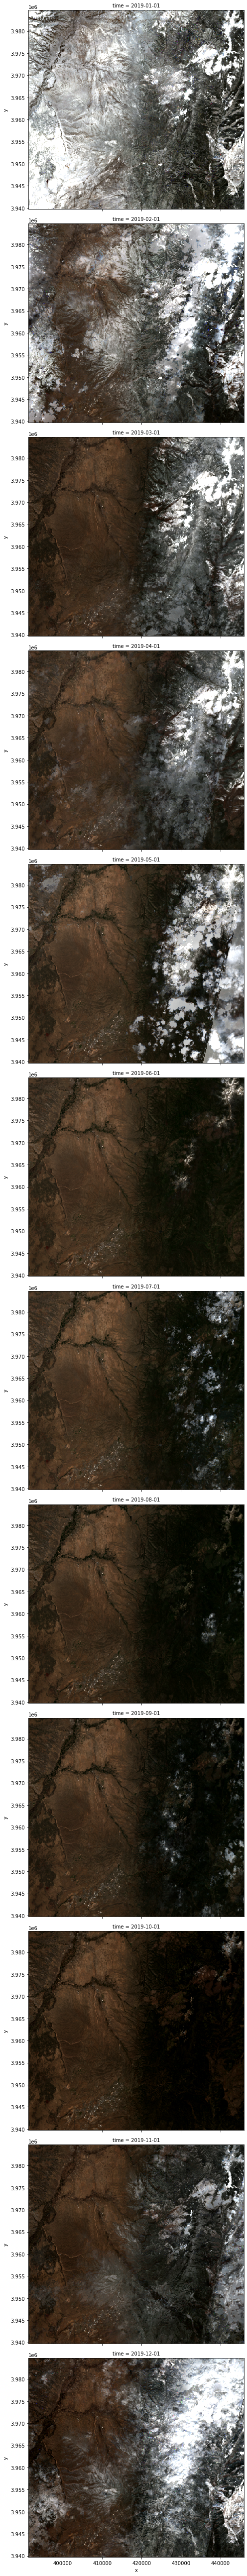

In [10]:
rgb_.plot.imshow(row="time", rgb="band", robust=True, size=6);

In [11]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.27508544921875, 47.54687159892238],
            [-121.96128845214844, 47.54687159892238],
            [-121.96128845214844, 47.745787772920934],
            [-122.27508544921875, 47.745787772920934],
            [-122.27508544921875, 47.54687159892238],
        ]
    ],
}
bbox = rasterio.features.bounds(area_of_interest)

In [23]:
import pystac_client

stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bbox,
    datetime="2020-01-10/2020-08-14",
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 25}},
)

items = list(search.get_items())
print(len(items))

20


In [24]:
import planetary_computer

signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [25]:
data = (
    stackstac.stack(
        signed_items,
        assets=["B04", "B03", "B02"],  # red, green, blue
        chunksize=4096,
        resolution=100,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)
data

<xarray.DataArray 'stackstac-bf32494799a2bbc830b5dd7e8609d8c6' (time: 20, band: 3, y: 1099, x: 1099)>
dask.array<where, shape=(20, 3, 1099, 1099), dtype=float64, chunksize=(1, 1, 1099, 1099), chunktype=numpy.ndarray>
Coordinates:
  * time                                     (time) datetime64[ns] 2020-02-02...
    id                                       (time) <U54 'S2B_MSIL2A_20200202...
  * band                                     (band) <U5 'red' 'green' 'blue'
  * x                                        (x) float64 4.999e+05 ... 6.097e+05
  * y                                        (y) float64 5.3e+06 ... 5.19e+06
    s2:product_type                          <U7 'S2MSI2A'
    s2:high_proba_clouds_percentage          (time) float64 10.51 ... 2.064
    s2:water_percentage                      (time) float64 11.05 ... 11.03
    sat:relative_orbit                       (time) int64 13 56 56 ... 13 13 56
    platform                                 (time) <U11 'Sentinel-2B' ... 'S...
    s2:degraded_msi_data_percentage          float64 0.0
    s2:datastrip_id                          (time) <U64 'S2B_OPER_MSI_L2A_DS...
    sat:orbit_state                          <U10 'descending'
    s2:datatake_type                         <U8 'INS-NOBS'
    eo:cloud_cover                           (time) float64 17.34 ... 9.001
    s2:unclassified_percentage               (time) float64 10.14 ... 1.739
    s2:processing_baseline                   <U5 '02.12'
    s2:cloud_shadow_percentage               (time) float64 10.27 ... 1.205
    s2:snow_ice_percentage                   (time) float64 2.91 ... 0.2792
    s2:nodata_pixel_percentage               (time) float64 4.416 ... 1.003
    s2:mean_solar_azimuth                    (time) float64 161.3 ... 157.4
    s2:datatake_id                           (time) <U34 'GS2B_20200202T19060...
    proj:epsg                                int64 32610
    s2:mgrs_tile                             <U5 '10TET'
    s2:granule_id                            (time) <U62 'S2B_OPER_MSI_L2A_TL...
    s2:product_uri                           (time) <U65 'S2B_MSIL2A_20200202...
    instruments                              <U3 'msi'
    s2:dark_features_percentage              (time) float64 12.39 ... 1.331
    s2:generation_time                       (time) <U24 '2020-09-30T14:05:04...
    s2:vegetation_percentage                 (time) float64 32.28 55.8 ... 66.35
    s2:not_vegetated_percentage              (time) float64 3.619 5.66 ... 9.061
    s2:saturated_defective_pixel_percentage  float64 0.0
    s2:medium_proba_clouds_percentage        (time) float64 6.208 ... 1.073
    constellation                            <U10 'Sentinel 2'
    s2:thin_cirrus_percentage                (time) float64 0.6194 ... 5.864
    s2:reflectance_conversion_factor         (time) float64 1.031 ... 0.9735
    s2:mean_solar_zenith                     (time) float64 66.13 ... 34.77
    proj:transform                           object {0.0, 5300040.0, 10.0, 49...
    gsd                                      int64 10
    title                                    (band) <U20 'Band 4 - Red - 10m'...
    proj:shape                               object {10980}
    proj:bbox                                object {5190240.0, 609780.0, 499...
    common_name                              (band) <U5 'red' 'green' 'blue'
    center_wavelength                        (band) float64 0.665 0.56 0.49
    full_width_half_max                      (band) float64 0.038 0.045 0.098
    epsg                                     int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(499900, 5190200, 609800, 5300...
    crs:         epsg:32610
    transform:   | 100.00, 0.00, 499900.00|\n| 0.00,-100.00, 5300100.00|\n| 0...
    resolution:  100

In [26]:
data = data.persist()

In [ ]:
median = data.median(dim="time").compute()

KeyboardInterrupt: 

In [ ]:
image = ms.true_color(*median)  # expects red, green, blue DataArrays

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

ax.set_axis_off()
image.plot.imshow(ax=ax);

## Shutdown Dask Cluster

Important! Don't forget to shut down the cluster using the following commands:

In [37]:
coiled.list_clusters()

{}

In [14]:
coiled.delete_cluster(name="stackstac")  # Add your cluster name here
# client.close()  # Close the client as well

Cluster deleted successfully.